In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.distributions import constraints

import pyro
from pyro.distributions import *
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.optim import Adam

assert pyro.__version__.startswith('1.8.6')
pyro.set_rng_seed(0)

/tmp/ipykernel_3565477/1526901925.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/tscc/nfs/home/hsher/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


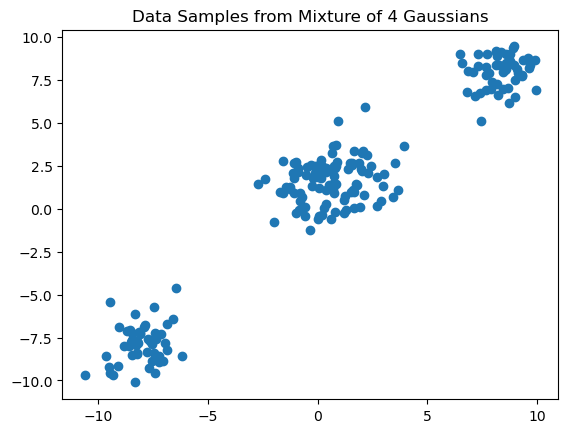

In [2]:
data = torch.cat((MultivariateNormal(-8 * torch.ones(2), torch.eye(2)).sample([50]),
                  MultivariateNormal(8 * torch.ones(2), torch.eye(2)).sample([50]),
                  MultivariateNormal(torch.tensor([1.5, 2]), torch.eye(2)).sample([50]),
                  MultivariateNormal(torch.tensor([-0.5, 1]), torch.eye(2)).sample([50])))

plt.scatter(data[:, 0], data[:, 1])
plt.title("Data Samples from Mixture of 4 Gaussians")
plt.show()
N = data.shape[0]

In [3]:
def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)


In [4]:
def model(data):
    # stick breaking method
    # T: clusters
    with pyro.plate("beta_plate", T-1):
        beta = pyro.sample("beta", Beta(1, alpha))

    with pyro.plate("mu_plate", T):
        # G0 is a Multivariate Gaussian with mean and identitfy sigma
        mu = pyro.sample("mu", MultivariateNormal(torch.zeros(2), 5 * torch.eye(2)))

    with pyro.plate("data", N):
        # cluster assignment z
        z = pyro.sample("z", Categorical(mix_weights(beta)))

        # sample our observation
        pyro.sample("obs", MultivariateNormal(mu[z], torch.eye(2)), obs=data)


In [5]:
def guide(data):
    kappa = pyro.param('kappa', lambda: Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
    tau = pyro.param('tau', lambda: MultivariateNormal(torch.zeros(2), 3 * torch.eye(2)).sample([T]))
    phi = pyro.param('phi', lambda: Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

    with pyro.plate("beta_plate", T-1):
        # T-1 conditionally independent betas sampled
        q_beta = pyro.sample("beta", Beta(torch.ones(T-1), kappa))

    with pyro.plate("mu_plate", T):
        # T conditionally independent multivariant gaussians
        q_mu = pyro.sample("mu", MultivariateNormal(tau, torch.eye(2)))

    with pyro.plate("data", N):
        # N conditionally independent cluster assignment variables z_n for sample n
        z = pyro.sample("z", Categorical(phi))



100%|██████████| 1000/1000 [00:07<00:00, 141.55it/s]


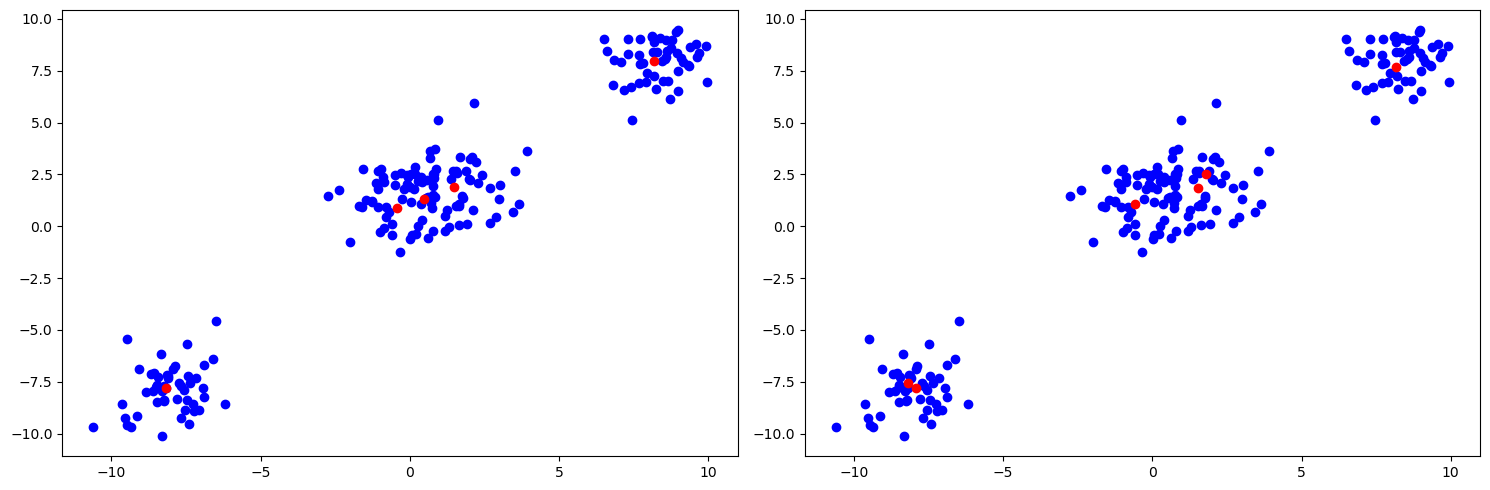

In [6]:
# set to have at most 6 clusters
T = 6
# optimizer
optim = Adam({"lr": 0.05})
svi = SVI(model, guide, optim, loss=Trace_ELBO())
losses = []

def train(num_iterations):
    pyro.clear_param_store()
    for j in tqdm(range(num_iterations)):
        loss = svi.step(data)
        losses.append(loss)

def truncate(alpha, centers, weights):
    threshold = alpha**-1 / 100.
    true_centers = centers[weights > threshold]
    true_weights = weights[weights > threshold] / torch.sum(weights[weights > threshold])
    return true_centers, true_weights

alpha = 0.1
train(1000)

# We make a point-estimate of our model parameters using the posterior means of tau and phi for the centers and weights
Bayes_Centers_01, Bayes_Weights_01 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))

alpha = 1.5
train(1000)

# We make a point-estimate of our model parameters using the posterior means of tau and phi for the centers and weights
Bayes_Centers_15, Bayes_Weights_15 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))

plt.figure(figsize=(15, 5))
plt.title('alpha = 0.1, less new clusters')
plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], color="blue")
plt.scatter(Bayes_Centers_01[:, 0], Bayes_Centers_01[:, 1], color="red")

plt.subplot(1, 2, 2)
plt.title('alpha = 1.5, more new clusters')
plt.scatter(data[:, 0], data[:, 1], color="blue")
plt.scatter(Bayes_Centers_15[:, 0], Bayes_Centers_15[:, 1], color="red")
plt.tight_layout()
plt.show()

# Application on Long term solar observations

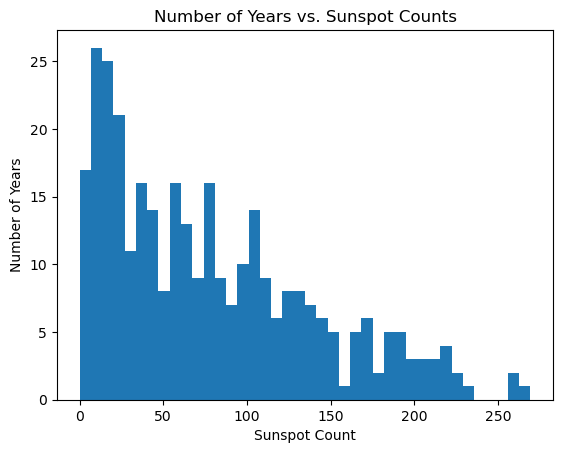

In [9]:
df = pd.read_csv('http://www.sidc.be/silso/DATA/SN_y_tot_V2.0.csv', sep=';', names=['time', 'sunspot.year'], usecols=[0, 1])
data = torch.tensor(df['sunspot.year'].values, dtype=torch.float32).round()
N = data.shape[0]

plt.hist(df['sunspot.year'].values, bins=40)
plt.title("Number of Years vs. Sunspot Counts")
plt.xlabel("Sunspot Count")
plt.ylabel("Number of Years")
plt.show()

(array([ 1.,  0.,  4.,  8.,  8., 15., 21., 17., 17., 22., 21., 25., 28.,
        25., 29., 26., 18., 36., 26., 30., 29., 17., 34., 17., 27., 21.,
        23., 21., 28., 25., 23., 24., 20., 30., 24., 15., 12., 10., 13.,
        10., 14., 12., 17., 14.,  7.,  8., 17.,  7., 10.,  3.,  6.,  9.,
         5.,  3.,  5.,  6.,  3.,  2.,  3.,  5.,  1.,  2.,  2.,  2.,  4.,
         3.,  2.,  3.,  4.,  1.,  0.,  2.,  2.,  3.,  2.,  1.,  1.,  0.,
         1.,  0.,  0.,  1.,  0.,  0.,  0.,  2.,  0.,  1.,  0.,  1.,  0.,
         0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([  2.51703382,   4.5511651 ,   6.58529615,   8.61942768,
         10.65355873,  12.68768978,  14.72182178,  16.75595284,
         18.79008484,  20.82421494,  22.85834694,  24.89247704,
         26.92660904,  28.96074104,  30.99487114,  33.02900314,
         35.06313324,  37.09726715,  39.13139725,  41.16552734,
         43.19965744,  45.23379135,  47.26792145,  49.30205154,
         51.33618546,  53.37031555,  55.40444565, 

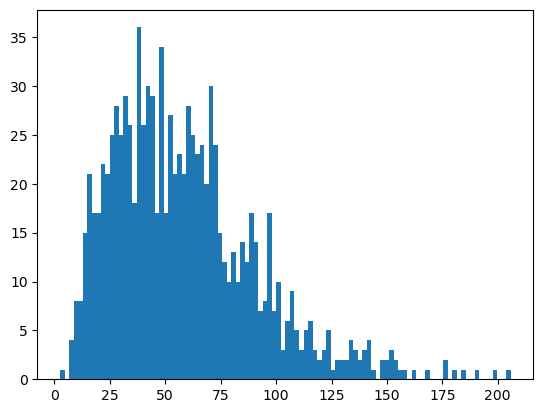

In [21]:
g = Gamma(3, 0.05)
plt.hist([g.sample() for i in range(1000)], bins = 100)

In [10]:
def model(data):
    with pyro.plate("beta_plate", T-1):
        beta = pyro.sample("beta", Beta(1, alpha))

    # parameter of lambdas: that parameterized Poisson
    # Gamma is the conjugate Prior of Poisson!
    # does not strictly matter for doing inference from Pyro
    with pyro.plate("lambda_plate", T):
        lmbda = pyro.sample("lambda", Gamma(3, 0.05))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(mix_weights(beta)))
        pyro.sample("obs", Poisson(lmbda[z]), obs=data)

def guide(data):
    kappa = pyro.param('kappa', lambda: Uniform(0, 2).sample([T-1]), constraint=constraints.positive)

    # This is different for Gamma, taking in 2 params
    tau_0 = pyro.param('tau_0', lambda: Uniform(0, 5).sample([T]), constraint=constraints.positive)
    tau_1 = pyro.param('tau_1', lambda: LogNormal(-1, 1).sample([T]), constraint=constraints.positive)
    
    phi = pyro.param('phi', lambda: Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

    with pyro.plate("beta_plate", T-1):
        q_beta = pyro.sample("beta", Beta(torch.ones(T-1), kappa))

    with pyro.plate("lambda_plate", T):
        q_lambda = pyro.sample("lambda", Gamma(tau_0, tau_1))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(phi))



In [8]:
# make it GPU 
# https://forum.pyro.ai/t/dirichlet-process-mixture-model-modification-gpu-code-use-of-particles-discrete-enumeration/5619/11

100%|██████████| 1500/1500 [00:09<00:00, 160.56it/s]


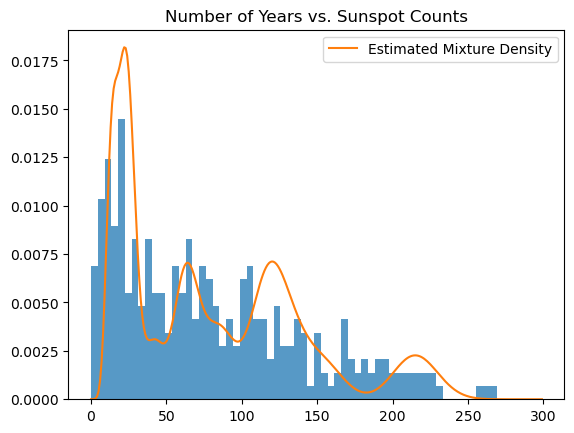

In [11]:
T = 20
alpha = 1.1
n_iter = 1500
optim = Adam({"lr": 0.05})
svi = SVI(model, guide, optim, loss=Trace_ELBO())
losses = []

train(n_iter)

samples = torch.arange(0, 300).type(torch.float)

tau0_optimal = pyro.param("tau_0").detach()
tau1_optimal = pyro.param("tau_1").detach()
kappa_optimal = pyro.param("kappa").detach()

# We make a point-estimate of our latent variables using the posterior means of tau and kappa for the cluster params and weights
Bayes_Rates = (tau0_optimal / tau1_optimal)
Bayes_Weights = mix_weights(1. / (1. + kappa_optimal))

def mixture_of_poisson(weights, rates, samples):
    return (weights * Poisson(rates).log_prob(samples.unsqueeze(-1)).exp()).sum(-1)

likelihood = mixture_of_poisson(Bayes_Weights, Bayes_Rates, samples)

plt.title("Number of Years vs. Sunspot Counts")
plt.hist(data.numpy(), bins=60, density=True, lw=0, alpha=0.75);
plt.plot(samples, likelihood, label="Estimated Mixture Density")
plt.legend()
plt.show()

In [13]:
Bayes_Rates # lambda for Poisson

tensor([ 22.5134,  67.2534,  42.5382,  64.7621, 114.3511, 136.8005,  21.5788,
        215.4865,  88.3545, 156.1149,  63.8027,  26.0570,  24.6386,  15.8620,
         80.6148, 138.9894, 116.3141,  13.5909,  61.8721, 124.6500])

In [14]:
Bayes_Weights

tensor([0.0444, 0.0153, 0.0468, 0.0323, 0.0627, 0.0384, 0.0257, 0.0834, 0.0594,
        0.0485, 0.0548, 0.0747, 0.0726, 0.0586, 0.0291, 0.0119, 0.0505, 0.0724,
        0.0353, 0.0832])

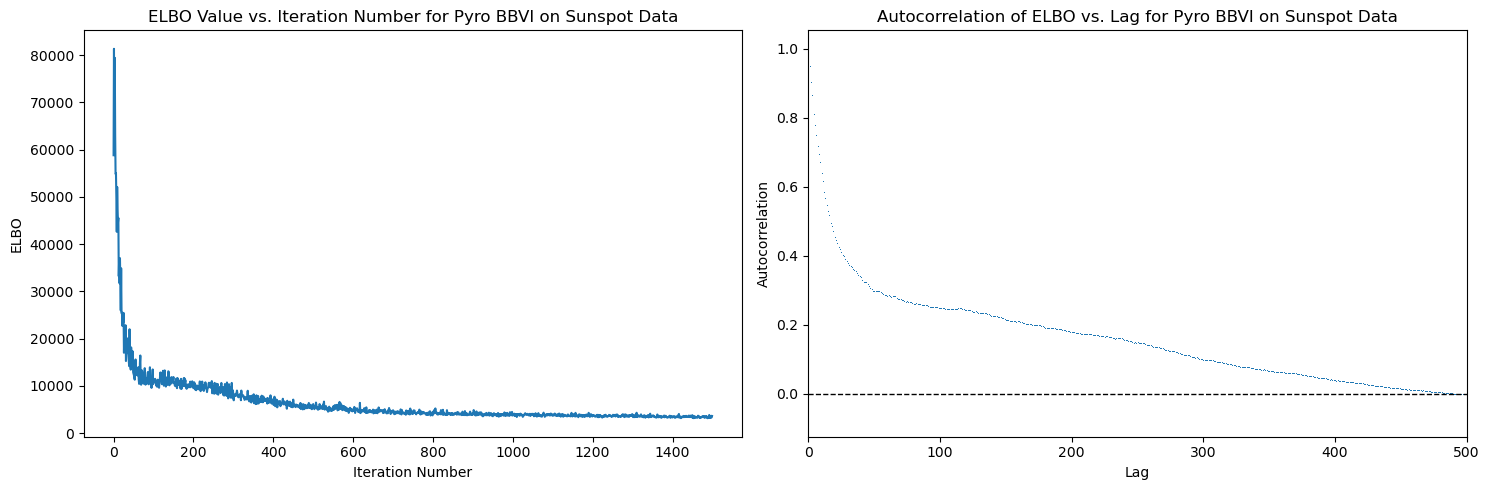

In [15]:
elbo_plot = plt.figure(figsize=(15, 5))

elbo_ax = elbo_plot.add_subplot(1, 2, 1)
elbo_ax.set_title("ELBO Value vs. Iteration Number for Pyro BBVI on Sunspot Data")
elbo_ax.set_ylabel("ELBO")
elbo_ax.set_xlabel("Iteration Number")
elbo_ax.plot(np.arange(n_iter), losses)

autocorr_ax = elbo_plot.add_subplot(1, 2, 2)
autocorr_ax.acorr(np.asarray(losses), detrend=lambda x: x - x.mean(), maxlags=750, usevlines=False, marker=',')
autocorr_ax.set_xlim(0, 500)
autocorr_ax.axhline(0, ls="--", c="k", lw=1)
autocorr_ax.set_title("Autocorrelation of ELBO vs. Lag for Pyro BBVI on Sunspot Data")
autocorr_ax.set_xlabel("Lag")
autocorr_ax.set_ylabel("Autocorrelation")
elbo_plot.tight_layout()
plt.show()
